# Load Libraries

In [179]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from matplotlib import rcParams
import squidpy as sq
import PIL
# import anndata as ad

# Load Data Set

In [180]:
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 0 # 3 for more info

adata = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# Filter Data

In [181]:
print(f"cells before MT filter: {adata.n_obs}")
sc.pp.filter_cells(adata, min_counts=5000)
sc.pp.filter_cells(adata, max_counts=35000)
adata = adata[adata.obs["pct_counts_mt"] < 20]
print(f"cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

cells before MT filter: 4035
cells after MT filter: 3861


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


# Sub sample down

In [182]:
adata_subsample = sc.pp.subsample(adata,fraction=0.75,copy=True)

# MLP

In [183]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [184]:
def positionalencoding2d(d_model, height, width):
    """
    :param d_model: dimension of the model
    :param height: height of the positions
    :param width: width of the positions
    :return: d_model*height*width position matrix
    """
    if d_model % 2 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with "
                         "odd dimension (got dim={:d})".format(d_model))
    pe = np.zeros((d_model, height, width))
    # Each dimension use half of d_model
    d_model = int(d_model / 2)
    div_term = np.exp(np.arange(0., d_model, 2) *
                         -(np.log(10000.0) / d_model))
    pos_w = np.expand_dims(np.arange(0., width), axis=1)
    pos_h = np.expand_dims(np.arange(0., height), axis=1)
    pe[0:d_model:2, :, :] = np.tile(np.expand_dims(np.swapaxes(np.sin(pos_w * div_term), 0, 1), axis=1), (1, height, 1))
    pe[1:d_model:2, :, :] = np.tile(np.expand_dims(np.swapaxes(np.cos(pos_w * div_term), 0, 1), axis=1), (1, height, 1))
    pe[d_model::2, :, :] = np.tile(np.expand_dims(np.swapaxes(np.sin(pos_h * div_term), 0, 1), axis=2), (1, 1, width))
    pe[d_model + 1::2, :, :] = np.tile(np.expand_dims(np.swapaxes(np.cos(pos_h * div_term), 0, 1), axis=2), (1, 1, width))

    return pe

In [185]:
# Turn coordinates into positional encodings
coordinates = (adata_subsample.obsm["spatial"] / 100).astype(int)

max_range = coordinates.max(axis=0)
min_range = coordinates.min(axis=0)

encoding_dim = 128
p_enc_2d = positionalencoding2d(encoding_dim, int(max_range[0] - min_range[0]) + 1, int(max_range[1] - min_range[1]) + 1)
X = np.zeros((coordinates.shape[0], encoding_dim))
print(X.shape)
for idx, i in enumerate(coordinates):
    X[idx] = p_enc_2d[:, i[0] - min_range[0], i[1] - min_range[1]]

# Gene expression
y = adata_subsample[:, adata_subsample.var.highly_variable].X.A


# Split testing and training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05, random_state=42)

(2895, 128)


In [186]:
#Define Sequential model with 3 layers
model = keras.Sequential(
    [
        keras.Input(shape=(encoding_dim,)),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(y.shape[1])
    ]
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 128)               16512     
                                                                 
 dense_21 (Dense)            (None, 128)               16512     
                                                                 
 dense_22 (Dense)            (None, 128)               16512     
                                                                 
 dense_23 (Dense)            (None, 2000)              258000    
                                                                 
Total params: 307,536
Trainable params: 307,536
Non-trainable params: 0
_________________________________________________________________


In [187]:
# Call model on a test input
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="mse")
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=[callback], batch_size=8)

Epoch 1/100
344/344 [==============================] - 1s 2ms/step - loss: 0.1259 - val_loss: 0.1096
Epoch 2/100
344/344 [==============================] - 1s 2ms/step - loss: 0.1073 - val_loss: 0.1053
Epoch 3/100
344/344 [==============================] - 1s 2ms/step - loss: 0.1038 - val_loss: 0.1029
Epoch 4/100
344/344 [==============================] - 1s 2ms/step - loss: 0.1013 - val_loss: 0.1016
Epoch 5/100
344/344 [==============================] - 1s 2ms/step - loss: 0.0996 - val_loss: 0.1010
Epoch 6/100
344/344 [==============================] - 1s 2ms/step - loss: 0.0986 - val_loss: 0.1010
Epoch 7/100
344/344 [==============================] - 1s 2ms/step - loss: 0.0975 - val_loss: 0.0992
Epoch 8/100
344/344 [==============================] - 1s 2ms/step - loss: 0.0966 - val_loss: 0.0989
Epoch 9/100
344/344 [==============================] - 1s 2ms/step - loss: 0.0961 - val_loss: 0.1000
Epoch 10/100
344/344 [==============================] - 1s 2ms/step - loss: 0.0954 - val_lo

# Re rendering cells

In [188]:
x_cont = np.arange(0, p_enc_2d.shape[1]) + min_range[0]
y_cont = np.arange(0, p_enc_2d.shape[2]) + min_range[0]
xx, yy = np.meshgrid(x_cont, y_cont)
adata

AnnData object with n_obs × n_vars = 3861 × 19685
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial'

In [189]:
flatten_encoding = np.transpose(p_enc_2d.reshape(encoding_dim, -1))
print(flatten_encoding.shape)
output = model.predict(flatten_encoding)

mlp_Z = output.reshape(xx.shape[1], xx.shape[0], output.shape[1])
mlp_Z = np.flip(np.swapaxes(mlp_Z, 0, 1), 0)

print(mlp_Z.shape)

(7708, 128)
(94, 82, 2000)


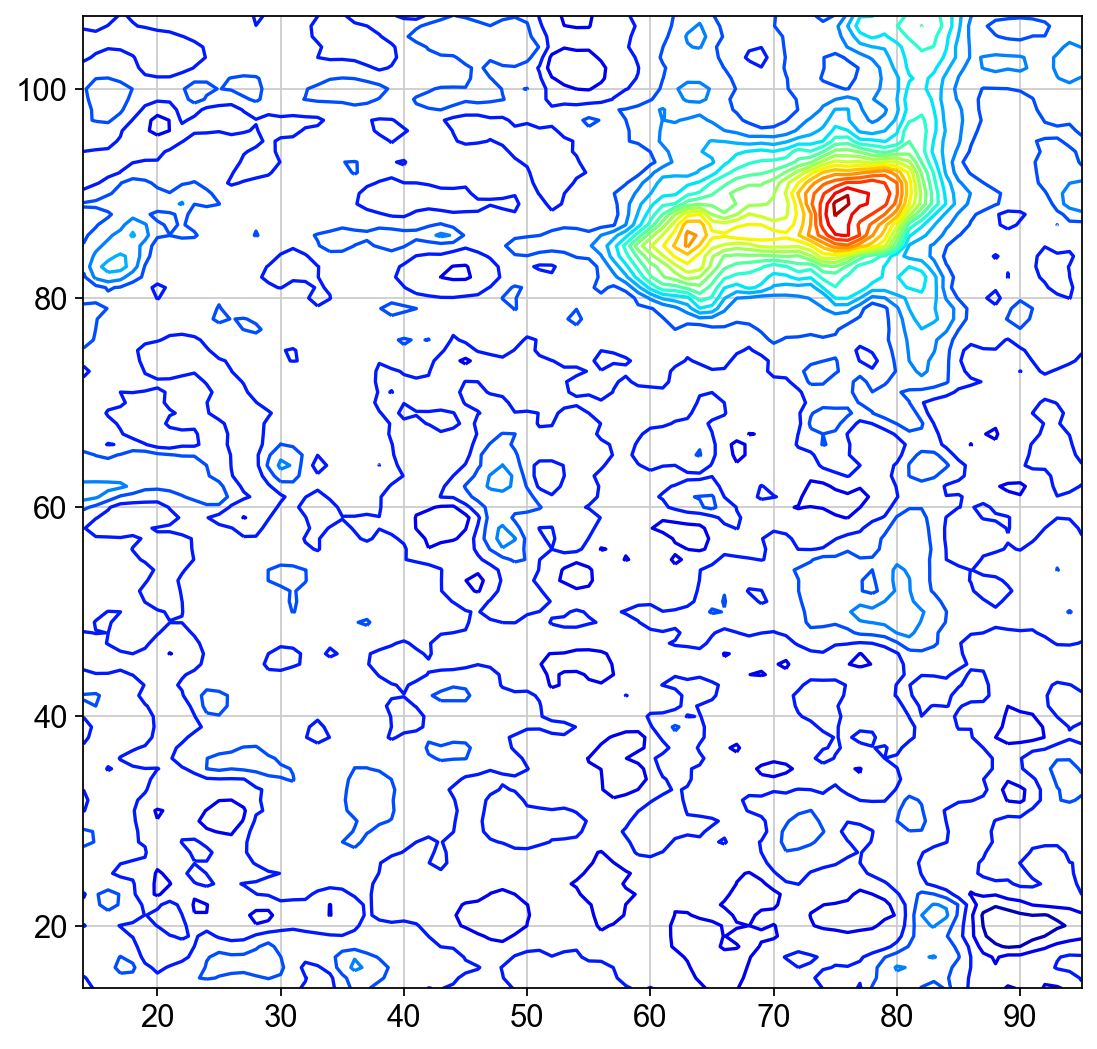

In [190]:
genes = adata_subsample.var.index[adata_subsample.var.highly_variable]
gene_name = genes[2]

plt.figure()
plt.contour(xx, yy, mlp_Z[:, :, np.where(genes == gene_name)[0][0]], 20, cmap='jet');
plt.show()



# Linear Regression

In [212]:
from sklearn.linear_model import LinearRegression

coordinates = (adata_subsample.obsm["spatial"]/100).astype(int)
y = adata_subsample[:, adata_subsample.var.highly_variable].X.A
reg = LinearRegression().fit(coordinates, y)


height_range = range(0,int(max_range[0] - min_range[0]) + 1)
width_range = range(int(max_range[1] - min_range[1]) + 1)

val_cells = np.zeros((len(height_range)*len(width_range),2))

print(val_cells.shape)

cell_count = 0 
for width in width_range:
    for height in height_range:
        val_cells[cell_count]  = np.array([height,width])
        cell_count +=1


linear_output = reg.predict(val_cells)

#print(linear_output.shape)
linear_Z = linear_output.reshape(xx.shape[1], xx.shape[0], linear_output.shape[1])
linear_Z = np.flip(np.swapaxes(linear_Z, 0, 1), 0)


(7708, 2)


(94, 82, 2000)


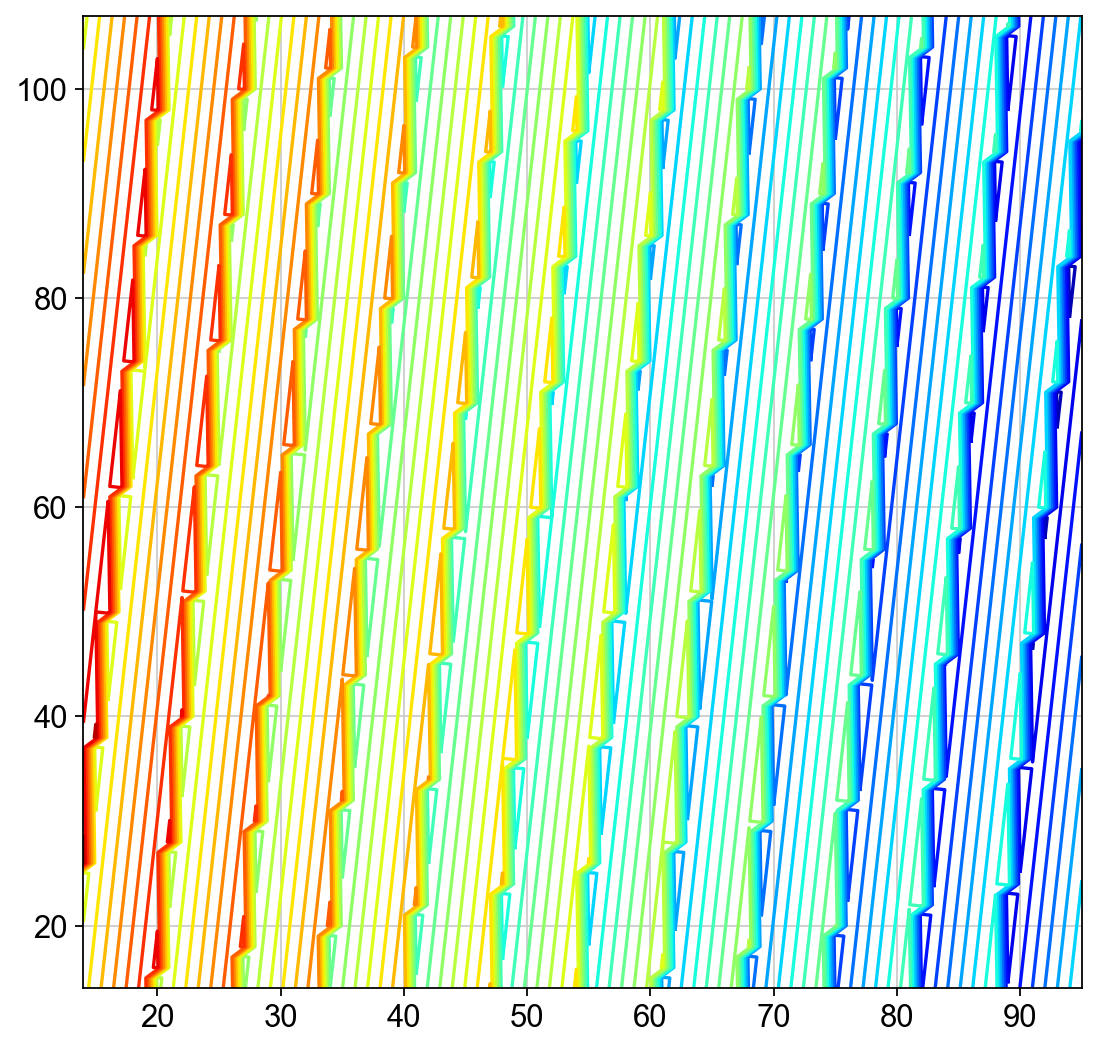

In [211]:
plt.figure()


x_cont = np.arange(0, linear_Z.shape[1]) + min_range[0]
y_cont = np.arange(0, linear_Z.shape[0]) + min_range[0]
xx, yy = np.meshgrid(x_cont, y_cont)

plt.contour(xx, yy, linear_Z[:, :, np.where(genes == gene_name)[0][0]], 20, cmap='jet')
plt.show()

# KNN

In [215]:
from sklearn.neighbors import KNeighborsRegressor

coordinates = (adata_subsample.obsm["spatial"] / 100).astype(int)
y = adata_subsample[:, adata_subsample.var.highly_variable].X.A
knn = KNeighborsRegressor().fit(coordinates, y)


height_range = range(0,int(max_range[0] - min_range[0]) + 1)
width_range = range(int(max_range[1] - min_range[1]) + 1)

val_cells = np.zeros((len(height_range)*len(width_range),2))

print(val_cells.shape)

cell_count = 0 
for width in width_range:
    for height in height_range:
        val_cells[cell_count]  = np.array([height,width])
        cell_count +=1


knn_output = knn.predict(val_cells)

#print(linear_output.shape)
knn_Z = linear_output.reshape(xx.shape[1], xx.shape[0], linear_output.shape[1])
knn_Z = np.flip(np.swapaxes(knn_Z, 0, 1), 0)

(7708, 2)


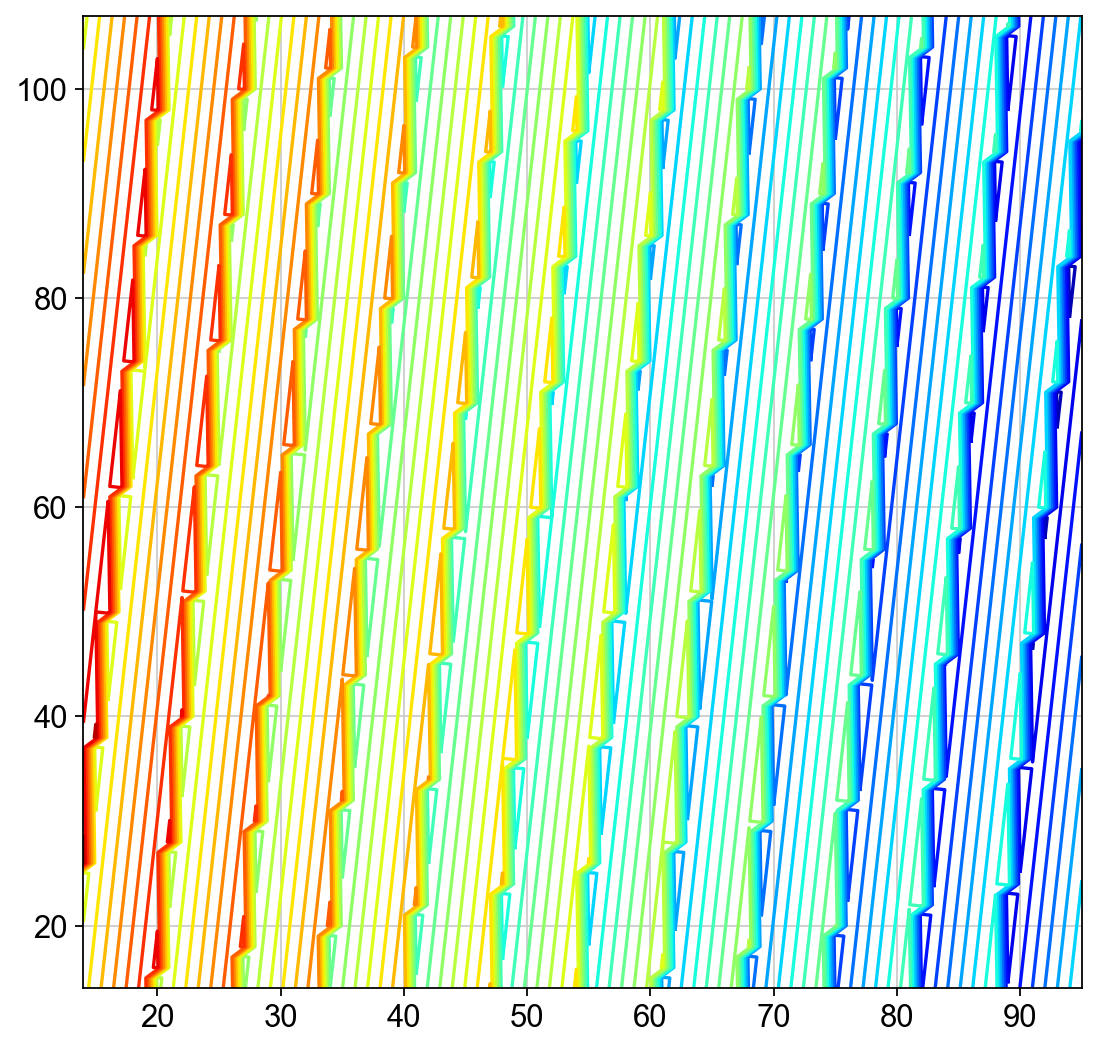

In [217]:
plt.figure()
plt.contour(xx, yy, knn_Z[:, :, np.where(genes == gene_name)[0][0]], 20, cmap='jet')
plt.show()